# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

The functions I need

In [3]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
SEED = 42

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [4]:
from sklearn.exceptions import NotFittedError

In [5]:
loss_history = []

In [6]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        return 1 / (1 + np.exp(- X @ weights))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>
        N = x.shape[0]
        result = 0
        for i in range(N):
            result += np.log(1 + np.exp(- (weights @ x[i]) * y[i]))
        result /= N
        result += (np.linalg.norm(weights) / (2 * self.C))  # ** 2
        #result += np.sum(np.abs(weights)) ** 2 / (2 * self.C)
        return result
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            N = X.shape[0]
            #delta = - (1 / N) * ((y @ X_ext) * (1 - 1 / (1 + np.exp(y @ (- X_ext * self.weights_))))) + self.weights_ / self.C
            #delta = - (1 / N) * ((y @ X_ext) * (1 - 1 / (1 + np.exp((- X_ext * self.weights_) @ y)))) - self.weights_ / self.C
            #delta = - (1 / N) * ((y @ X_ext) * (1 - 1 / (1 + np.exp((- X_ext * self.weights_).T @ y)))) + (1 / self.C) * self.weights_
            delta = 0
            for j in range(N):
                delta += y[j] * X_ext[j] * (1 - 1 / (1 + np.exp(- (self.weights_ @ X_ext[j]) * y[j])))
            delta /= N
            delta -= (1 / self.C) * self.weights_
            delta = -delta
            self.weights_ -= self.eta * delta
            
            loss_history.append(self.get_loss(X_ext, self.weights_, y))
            
            if np.linalg.norm(self.eta * delta) < self.tol:
            #if np.linalg.norm(delta) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) 
        #return np.array([1 if p > 0.5 else -1 for p in 1 / (1 + np.exp(- X_ext @ self.weights_))])
        #return np.array([1 if p > 0.5 else -1 for p in self.get_sigmoid(X_ext, self.weights_)])
        return np.array([1 if p > 0.5 else -1 for p in self.predict_proba(X)])

In [7]:
from sklearn import datasets
from sklearn import metrics

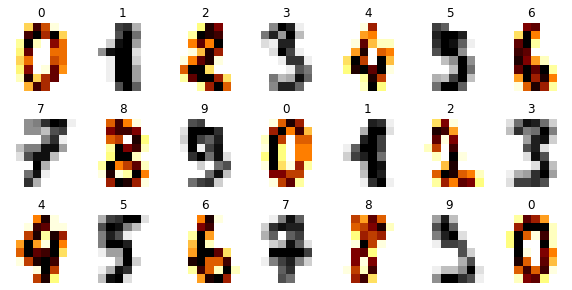

In [8]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [9]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [10]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [11]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [12]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [13]:
lr_clf.fit(X_train, y_train)

In [14]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [15]:
model = CustomLogisticRegression()

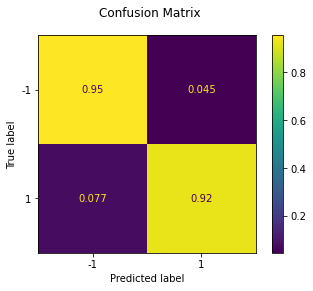

In [16]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [17]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

In [18]:
## your code
def loss_history_viz(lr_r):
    plt.plot(loss_history)
    plt.xlabel('iteration')
    plt.ylabel('value')
    plt.title('Loss history for eta = '+ str(lr_r));

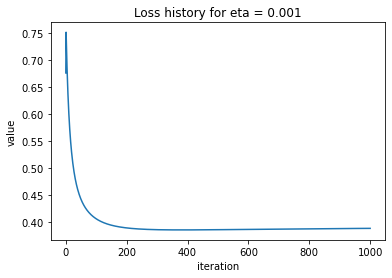

In [19]:
loss_history_viz(0.001)

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

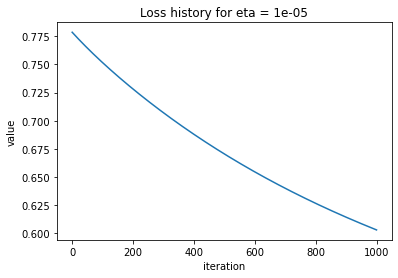

In [20]:
loss_history = []
model = CustomLogisticRegression(eta=0.00001)
model.fit(X_train, y_train)
loss_history_viz(0.00001)

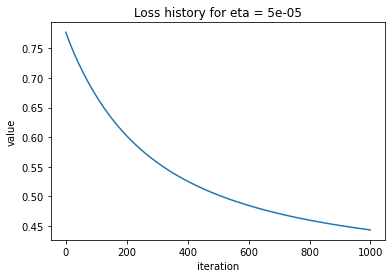

In [21]:
loss_history = []
model = CustomLogisticRegression(eta=0.00005)
model.fit(X_train, y_train)
loss_history_viz(0.00005)

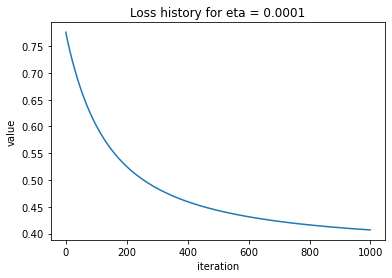

In [22]:
loss_history = []
model = CustomLogisticRegression(eta=0.0001)
model.fit(X_train, y_train)
loss_history_viz(0.0001)

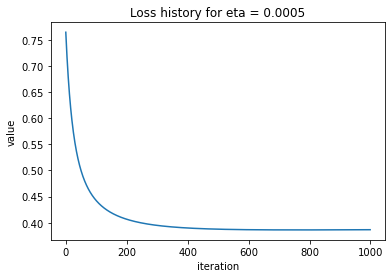

In [23]:
loss_history = []
model = CustomLogisticRegression(eta=0.0005)
model.fit(X_train, y_train)
loss_history_viz(0.0005)

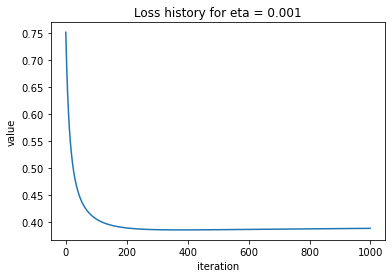

In [24]:
loss_history = []
model = CustomLogisticRegression(eta=0.001)
model.fit(X_train, y_train)
loss_history_viz(0.001)

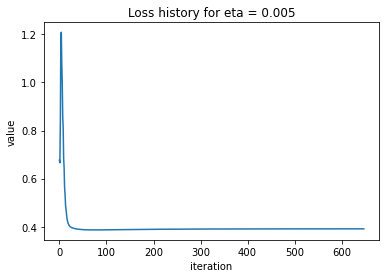

In [25]:
loss_history = []
model = CustomLogisticRegression(eta=0.005)
model.fit(X_train, y_train)
loss_history_viz(0.005)

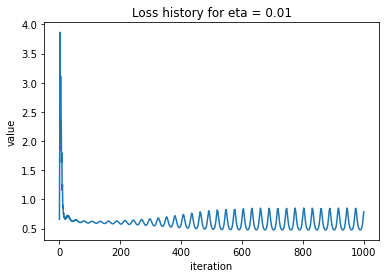

In [26]:
loss_history = []
model = CustomLogisticRegression(eta=0.01)
model.fit(X_train, y_train)
loss_history_viz(0.01)

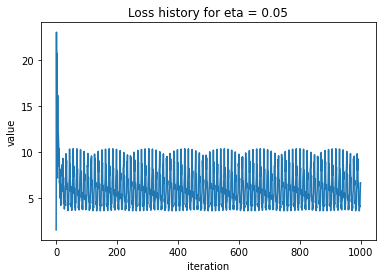

In [27]:
loss_history = []
model = CustomLogisticRegression(eta=0.05)
model.fit(X_train, y_train)
loss_history_viz(0.05)

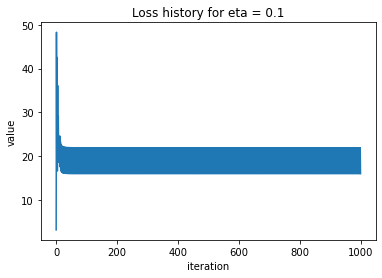

In [28]:
loss_history = []
model = CustomLogisticRegression(eta=0.1)
model.fit(X_train, y_train)
loss_history_viz(0.1)

In [29]:
#loss_history = []
#model = CustomLogisticRegression(eta=0.5)
#model.fit(X_train, y_train)
#loss_history_viz(0.5)

In [30]:
#loss_history = []
#model = CustomLogisticRegression(eta=1)
#model.fit(X_train, y_train)
#loss_history_viz(1)

**Comparison. How does the learning rate influence the convergence?** The less learning rate is, the slowlier the convergence is. For eta=0.00001 the plot is close to the line, in contrast for eta from 0.01 we can see a big "fall" at the beginning and "jumps" after it.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [31]:
train_test_acc_list = []

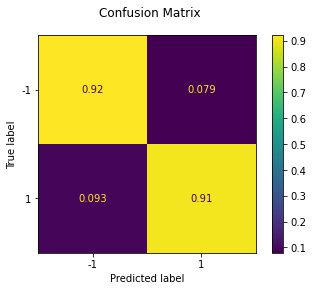

In [32]:
model = CustomLogisticRegression(C=0.1)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
train_test_acc_list.append((0.1, train_acc, test_acc))

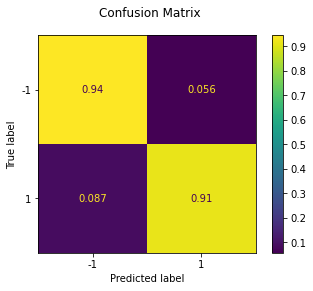

In [33]:
model = CustomLogisticRegression(C=0.5)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
train_test_acc_list.append((0.5, train_acc, test_acc))

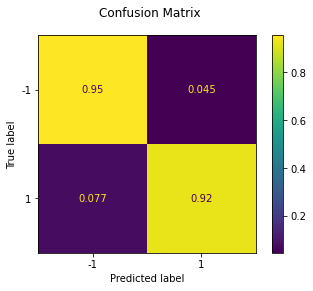

In [34]:
model = CustomLogisticRegression(C=1.0)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
train_test_acc_list.append((1.0, train_acc, test_acc))

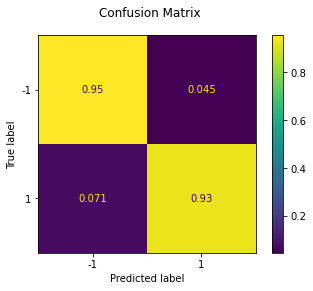

In [35]:
model = CustomLogisticRegression(C=1.5)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
train_test_acc_list.append((1.5, train_acc, test_acc))

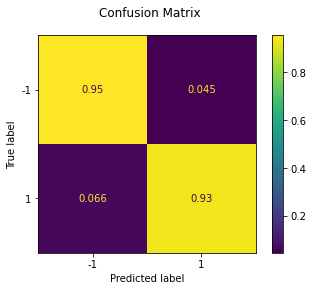

In [36]:
model = CustomLogisticRegression(C=2.0)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
train_test_acc_list.append((2.0, train_acc, test_acc))

In [37]:
train_test_acc_list

[(0.1, 0.8872651356993737, 0.9138888888888889),
 (0.5, 0.9039665970772442, 0.9277777777777778),
 (1.0, 0.9109255393180237, 0.9388888888888889),
 (1.5, 0.9130132219902575, 0.9416666666666667),
 (2.0, 0.9137091162143354, 0.9444444444444444)]

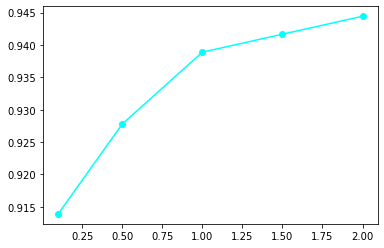

In [38]:
plt.plot([x[0] for x in train_test_acc_list], [x[2] for x in train_test_acc_list], marker='o', color='cyan');

**My thoughts.** We can see that the accuracy increases when C increases. Really, C is an inverse of regularization strength. Smaller C values specify stronger regularization.

**(0.5 points)** Compare zero initialization and random initialization. 

In [39]:
## your code
model = CustomLogisticRegression(zero_init=True)

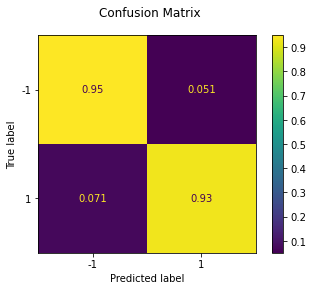

In [40]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [41]:
train_acc, test_acc

(0.9116214335421016, 0.9388888888888889)

That's zero initialization, random initialization is presented upper.

Train and test accuracy for **random initialization**: 0.9109255393180237, 0.9388888888888889

Train and test accuracy for **zero initialization**: 0.9116214335421016, 0.9388888888888889

**Comparison:** the test accuracy is equal, the train accuracy differs a bit. All in all, there's no real changes in these 2 types of initialization.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [42]:
from sklearn.metrics import pairwise_distances

In [43]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        N = X.shape[0]
        K = Y.shape[0]
        P = [[np.sqrt(np.sum(np.square(X[i] - Y[j]))) for j in range(K)] for i in range(N)]
        return np.array(P)
        #return pairwise_distances(X, Y)
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>
        N = len(y)
        P = []
        dict_P = {}
        for i in range(N):
            dict_P[y[i]] = dict_P.get(y[i], 0) + weights[i]
            
        for class_ in self.classes_:
            if class_ in dict_P.keys():
                P.append(dict_P[class_])
            else:
                P.append(0)
                
        return np.array(P)
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            weights_of_points_sorted = np.zeros(P.shape)
            if self.weights == 'distance':
                # initialization
                for i in range(P.shape[0]):
                    for j in range(P.shape[1]):
                        weights_of_points[i][j] = (1 / (P[i][j] + self.eps))
                # weights counting        
                for i in range(weights_of_points.shape[0]):
                    for j in np.argsort(-weights_of_points[i])[:self.n_neighbors:]:
                        weights_of_points_sorted[i][j] = weights_of_points[i][j]
            else:
                # no other initialization required
                # weights counting
                for i in range(P.shape[0]):
                    for j in np.argsort(P[i])[:self.n_neighbors:]:
                        weights_of_points_sorted[i][j] = 1

            class_weights = np.array([self.get_class_weights(self.y, weights_of_points_sorted[i]) 
                                              for i in range(weights_of_points_sorted.shape[0])])
            
            class_probabilities_normalized = np.array([[class_weights[i][j] / np.sum(class_weights[i]) 
                                                       for j in range(class_weights.shape[1])] 
                                              for i in range(class_weights.shape[0])])
            
            return class_probabilities_normalized       
            pass
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return np.argmax(self.predict_proba(X), axis=1)

In [44]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [45]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [46]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

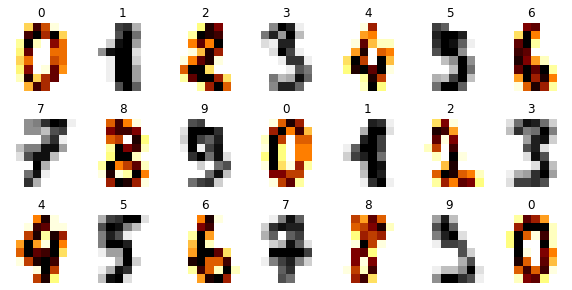

In [47]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [48]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [49]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

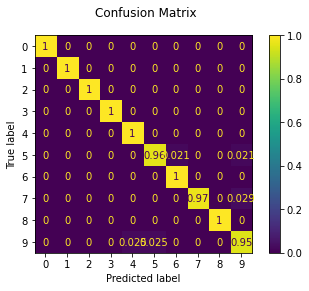

In [50]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [51]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

The model confuses:
* `5` and `6` 
* `5` and `9`
* `7` and `9`
* `9` and `4`
* `9` and `5`

This happens because the numbers can be written similarly

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [52]:
list_of_train_test_acc = []

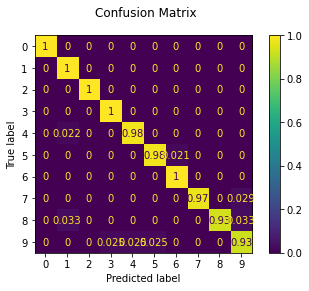

In [53]:
model = CustomKNeighborsClassifier(n_neighbors=1, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
list_of_train_test_acc.append((train_acc, test_acc))

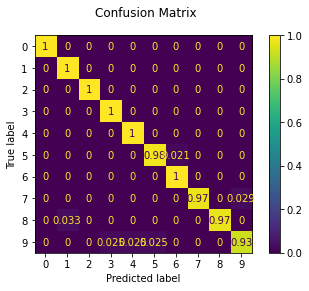

In [54]:
model = CustomKNeighborsClassifier(n_neighbors=3, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
list_of_train_test_acc.append((train_acc, test_acc))

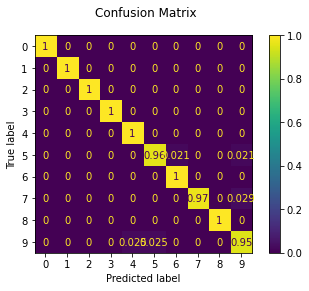

In [55]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
list_of_train_test_acc.append((train_acc, test_acc))

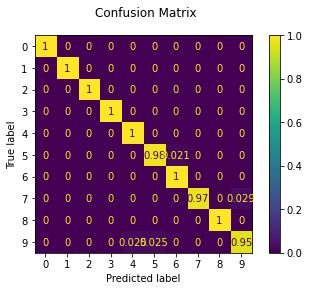

In [56]:
model = CustomKNeighborsClassifier(n_neighbors=7, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
list_of_train_test_acc.append((train_acc, test_acc))

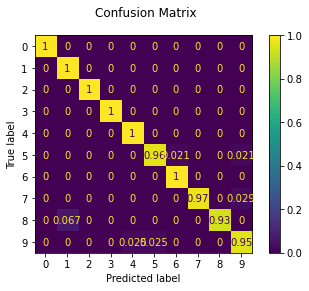

In [57]:
model = CustomKNeighborsClassifier(n_neighbors=9, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
list_of_train_test_acc.append((train_acc, test_acc))

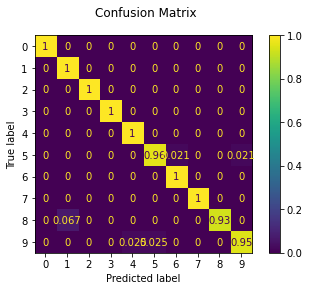

In [58]:
model = CustomKNeighborsClassifier(n_neighbors=11, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
list_of_train_test_acc.append((train_acc, test_acc))

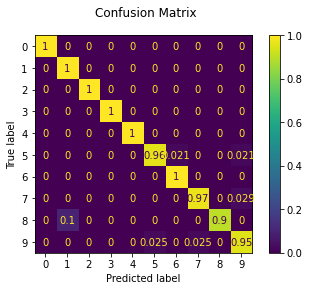

In [59]:
model = CustomKNeighborsClassifier(n_neighbors=13, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
list_of_train_test_acc.append((train_acc, test_acc))

In [60]:
list_of_train_test_acc

[(1.0, 0.9777777777777777),
 (1.0, 0.9833333333333333),
 (1.0, 0.9861111111111112),
 (1.0, 0.9888888888888889),
 (1.0, 0.9805555555555555),
 (1.0, 0.9833333333333333),
 (1.0, 0.9777777777777777)]

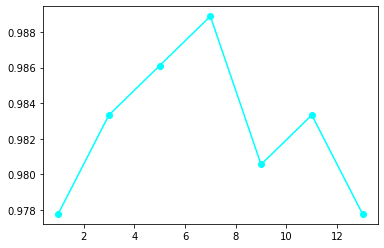

In [61]:
plt.plot([2 * i + 1 for i in range(7)], [x[1] for x in list_of_train_test_acc], marker='o', color='cyan');

**Comparison.** As we can see from the list and the plot, test accuracy is increasing while n_neighbors really increases, but after 7 it starts decreasing with jumps.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

I did a slightly changed classifier - predict proba there returns class weights.

In [62]:
class CustomKNeighborsClassifierForWeights:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        N = X.shape[0]
        K = Y.shape[0]
        P = [[np.sqrt(np.sum(np.square(X[i] - Y[j]))) for j in range(K)] for i in range(N)]
        return np.array(P)
        #return pairwise_distances(X, Y)
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>
        N = len(y)
        P = []
        dict_P = {}
        for i in range(N):
            dict_P[y[i]] = dict_P.get(y[i], 0) + weights[i]
            
        for class_ in self.classes_:
            if class_ in dict_P.keys():
                P.append(dict_P[class_])
            else:
                P.append(0)
                
        return np.array(P)
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            weights_of_points_sorted = np.zeros(P.shape)
            if self.weights == 'distance':
                # initialization
                for i in range(P.shape[0]):
                    for j in range(P.shape[1]):
                        weights_of_points[i][j] = (1 / (P[i][j] + self.eps))
                # weights counting        
                for i in range(weights_of_points.shape[0]):
                    for j in np.argsort(-weights_of_points[i])[:self.n_neighbors:]:
                        weights_of_points_sorted[i][j] = weights_of_points[i][j]
            else:
                # no other initialization required
                # weights counting
                for i in range(P.shape[0]):
                    for j in np.argsort(P[i])[:self.n_neighbors:]:
                        weights_of_points_sorted[i][j] = 1

            class_weights = np.array([self.get_class_weights(self.y, weights_of_points_sorted[i]) 
                                              for i in range(weights_of_points_sorted.shape[0])])
            
            class_probabilities_normalized = np.array([[class_weights[i][j] / np.sum(class_weights[i]) 
                                                       for j in range(class_weights.shape[1])] 
                                              for i in range(class_weights.shape[0])])
            
            return class_weights       
            pass
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return np.argmax(self.predict_proba(X), axis=1)

In [63]:
model_w = CustomKNeighborsClassifierForWeights(n_neighbors=5, weights='uniform')
model_w.fit(X_train, y_train)
weights_u = model_w.predict_proba(X_test)

In [64]:
weights_u[:10:]

array([[0., 0., 0., 0., 0., 0., 5., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 5.],
       [0., 0., 0., 5., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 5., 0., 0.],
       [0., 0., 5., 0., 0., 0., 0., 0., 0., 0.],
       [0., 5., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 5., 0., 0., 0., 0.],
       [0., 0., 5., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 5., 0., 0., 0., 0.],
       [0., 0., 5., 0., 0., 0., 0., 0., 0., 0.]])

In [65]:
model_w = CustomKNeighborsClassifierForWeights(n_neighbors=5, weights='distance')
model_w.fit(X_train, y_train)
weights_d = model_w.predict_proba(X_test)

In [66]:
weights_d[:10:]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.3002786 , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.23568812],
       [0.        , 0.        , 0.        , 0.32467343, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.3293907 , 0.        , 0.        ],
       [0.        , 0.        , 0.24409877, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.29614491, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.26635142, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.2185332

**My thoughts.** Here are the two variants of weights. In case of 'uniform' weights all the presented weights are similar (really, we have only 0 and 5 in the presented piece of data), in case of 'distant' weights they are "normalized". I think that if there are a lot of columns in the dataset, there could be situations with equal weights => cases of incorrect predictions even in the train set. So I think that it's better to use 'distance' weights when the dataset is more likely to have equal weights (for example, several similar columns). If the dataset is less likely to have equal weights, it's better to use 'uniform' weights - it requires less countings. When I experimented with Titanic dataset in task 3, 'uniform' weights worked better for my models.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

I think Hamming distance could improve the quality of the classification for this task because it uses not the pixel values difference but the fact of this difference. In fact it's the number of positions at which the corresponding symbols are different.

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

Task of deciding whether to give a credit to a bank client or not. Data: clients' parameters. Output: two classes - give credit or not. Distance function: euclidean distance.

I'm not really sure if it's a task of classification, so if it's not - I have a classification task above. Data: a lot of words with the mistakes in them. Output: correct words. Distance function: Levenshtein distance.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [67]:
PATH = "./data"

In [68]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [69]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [70]:
sex_data = pd.Series.to_frame(data.groupby('Sex')['Name'] \
                                          .aggregate('count')).reset_index().rename(columns={'Name': 'Amount'})
sex_data

,Sex,Amount
0,female,43886
1,male,56114


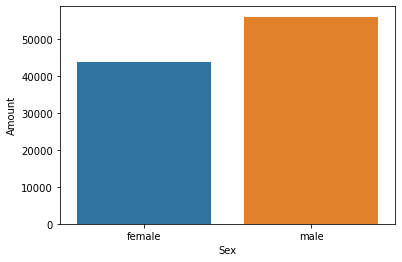

In [71]:
sns.barplot(x=sex_data.Sex, y=sex_data.Amount);

There are 43886 women and 56114 men in the dataset.

In [72]:
survived_data = pd.Series.to_frame(data.groupby('Survived')['Name'] \
                                          .aggregate('count')).reset_index().rename(columns={'Name': 'Amount'})
survived_data

,Survived,Amount
0,0,57226
1,1,42774


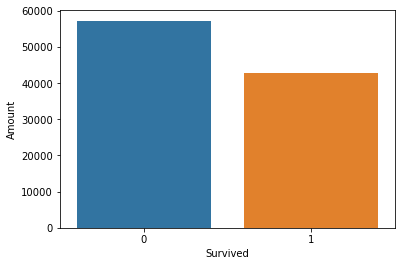

In [73]:
sns.barplot(x=survived_data.Survived, y=survived_data.Amount);

42774 passengers survived and 57226 didn't.

In [74]:
sex_survived_data = pd.Series.to_frame(data.groupby(['Sex', 'Survived'])['Name'] \
                                          .aggregate('count')).reset_index().rename(columns={'Name': 'Amount'})
sex_survived_data

,Sex,Survived,Amount
0,female,0,12660
1,female,1,31226
2,male,0,44566
3,male,1,11548


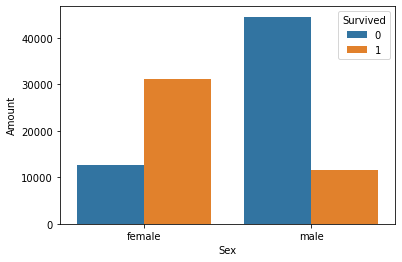

In [75]:
sns.barplot(x=sex_survived_data.Sex, y=sex_survived_data.Amount, hue=sex_survived_data.Survived);

Women: 31226 survived, 12660 didn't. Men: 11548 survived, 44566 didn't. 

We can see a **relationship between the gender and the survival:** women had a much bigger chance to survive.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

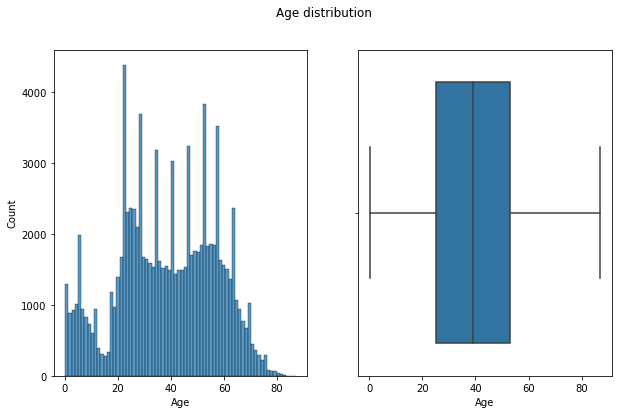

In [76]:
## your code
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle('Age distribution')

sns.histplot(ax=axes[0], x=data.Age);
sns.boxplot(x=data.Age);

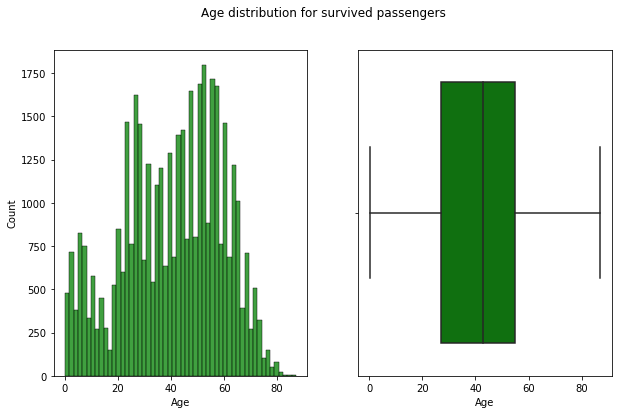

In [77]:
data_survived = data[data['Survived'] == 1]

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle('Age distribution for survived passengers')

sns.histplot(ax=axes[0], x=data_survived.Age, color='green');
sns.boxplot(x=data_survived.Age, color='green');

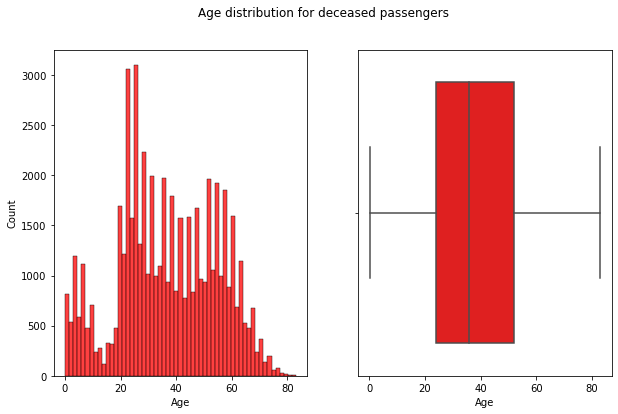

In [78]:
data_deceased = data[data['Survived'] == 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle('Age distribution for deceased passengers')

sns.histplot(ax=axes[0], x=data_deceased.Age, color='red');
sns.boxplot(x=data_deceased.Age, color='red');

The following piece of code demonstrates the average and the median age of survived and deceased passengers.

In [79]:
average_mean_ages = pd.DataFrame({'Survived': [data_survived.Age.mean(), data_survived.Age.median()],
                                  'Deceased': [data_deceased.Age.mean(), data_deceased.Age.median()]},
                                 index=['Average', 'Median'])
average_mean_ages

,Survived,Deceased
Average,40.553799,36.708695
Median,43.000000,36.000000


**Age distributions for survived and deceased passengers differs a bit:** the average and the median age is slightly less for the deceased passengers. I think this fact takes place because younger people had worse class than elder ones (in general, elder people have more  money and need more comfort), and better classes were safer than the worse ones.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [80]:
pclass_data = pd.Series.to_frame(data.groupby('Pclass')['Name'] \
                                          .aggregate('count')).reset_index().rename(columns={'Name': 'Amount'})
pclass_data

,Pclass,Amount
0,1,30315
1,2,28679
2,3,41006


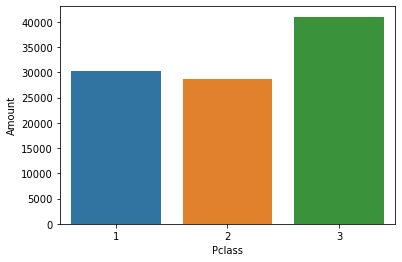

In [81]:
sns.barplot(x=pclass_data.Pclass, y=pclass_data.Amount);

There are 30315 passengers in the 1st class, 28679 in the 2nd and 41006 in the 3rd.

In [82]:
embarked_data = pd.Series.to_frame(data.groupby('Embarked')['Name'] \
                                          .aggregate('count')).reset_index().rename(columns={'Name': 'Amount'})
embarked_data

,Embarked,Amount
0,C,22187
1,Q,5424
2,S,72139


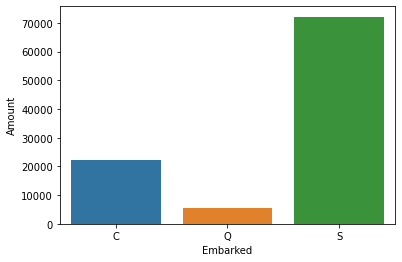

In [83]:
sns.barplot(x=embarked_data.Embarked, y=embarked_data.Amount);

22187 people started their cruise at Cherbourg, 5424 - at Queenstown and 72139 - at Southampton

Let's now see the dependence between passenger class and survival.

In [84]:
pclass_survived_data = pd.Series.to_frame(data.groupby(['Pclass', 'Survived'])['Name'] \
                                          .aggregate('count')).reset_index().rename(columns={'Name': 'Amount'})
pclass_survived_data

,Pclass,Survived,Amount
0,1,0,12739
1,1,1,17576
2,2,0,13622
3,2,1,15057
4,3,0,30865
5,3,1,10141


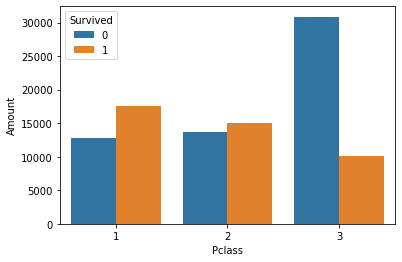

In [85]:
sns.barplot(x=pclass_survived_data.Pclass, y=pclass_survived_data.Amount, hue=pclass_survived_data.Survived);

After looking at the plots I think that the 1st class was "the safest". Let's count survival percentages to prove it.

In [86]:
dict_pclass_data = dict(data.groupby(['Pclass'])['Name'].aggregate('count'))
dict_pclass_data

{1: 30315, 2: 28679, 3: 41006}

In [87]:
pclass_survived_data['whole_amount'] = pclass_survived_data['Pclass'].map(dict_pclass_data)
pclass_survived_data['Percent_of_survived'] = pclass_survived_data['Amount'] / pclass_survived_data['whole_amount'] * 100
pclass_survived_data = pclass_survived_data.drop_duplicates('Pclass', keep='last').reset_index(drop=True).drop(['Survived', 'whole_amount'], axis=1)
pclass_survived_data

,Pclass,Amount,Percent_of_survived
0,1,17576,57.977899
1,2,15057,52.501831
2,3,10141,24.730527


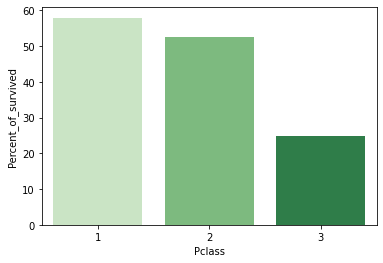

In [88]:
sns.barplot(x=pclass_survived_data.Pclass, y=pclass_survived_data.Percent_of_survived, palette='Greens');

The 1st class is really "the safest": there is the biggest percent of survived passengers.

Let's now see the dependence bwtween port and survival.

In [89]:
embarked_survived_data = pd.Series.to_frame(data.groupby(['Embarked', 'Survived'])['Name'] \
                                          .aggregate('count')).reset_index().rename(columns={'Name': 'Amount'})
embarked_survived_data

,Embarked,Survived,Amount
0,C,0,5518
1,C,1,16669
2,Q,0,2186
3,Q,1,3238
4,S,0,49394
5,S,1,22745


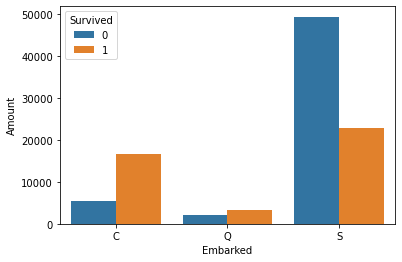

In [90]:
sns.barplot(x=embarked_survived_data.Embarked, y=embarked_survived_data.Amount, hue=embarked_survived_data.Survived);

It looks like Cherbourg is "the safest" embarkation port. Let's count percentages to check this hypothesis.

In [91]:
dict_embarked_data = dict(data.groupby(['Embarked'])['Name'].aggregate('count'))
dict_embarked_data

{'C': 22187, 'Q': 5424, 'S': 72139}

In [92]:
embarked_survived_data['whole_amount'] = embarked_survived_data['Embarked'].map(dict_embarked_data)
embarked_survived_data['Percent_of_survived'] = embarked_survived_data['Amount'] / embarked_survived_data['whole_amount'] * 100
embarked_survived_data = embarked_survived_data.drop_duplicates('Embarked', keep='last').reset_index(drop=True).drop(['Survived', 'whole_amount'], axis=1)
embarked_survived_data

,Embarked,Amount,Percent_of_survived
0,C,16669,75.129580
1,Q,3238,59.697640
2,S,22745,31.529409


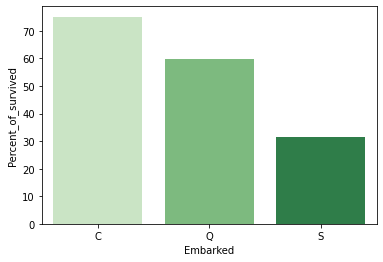

In [93]:
sns.barplot(x=embarked_survived_data.Embarked, y=embarked_survived_data.Percent_of_survived, palette='Greens');

Looks like there is the dependency between the embarkation port and the survival percentage - the highest percent is in Cherbourg, the lowest - in Southampton. But I don't think this is because of the port only - there might be a factor between them. For example, maybe those, who startet their cruise from Southampton, had cheaper places than those, who began their cruise at Cherbourg.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [94]:
percentage_of_missing_values = data.isnull().sum() * 100 / len(data)
missing_value_percentage = pd.DataFrame({'percentage_of_missing_values': percentage_of_missing_values})
missing_value_percentage

,percentage_of_missing_values
Survived,0.000
Pclass,0.000
Name,0.000
Sex,0.000
Age,3.292
SibSp,0.000
Parch,0.000
Ticket,4.623
Fare,0.134
Cabin,67.866


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

1. *Missing values in column `Embarked` can be filled with letter `S`, because the most part of people started their voyage at  Southampton. **Advantage:** can be realized simply. **Disadvantage:** doesn't consider the information about the particular person.*
2. *Missing values in the columns `Age` and `Fare` can be filled with the mean value of the columns' values according to the `Pclass`, because with the age and ticket cost increasing the class also increases (tickets cost more in more comfortable classes and elder people have more money => more comfortable class). **Advantages:** considers some facts about the person, is also simple for realization, but a little bit harder than the previous one. **Disadvantage:** doesn't consider the characteristics of a particular object.*

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

### Feature preparation

In [95]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


I'll drop columns `Ticket` and `Cabin` because I have no ideas of filling missing values there.

In [96]:
train_data = data.drop(['Ticket', 'Cabin'], axis=1)

Then I'll fill missing values in columns `Age`, `Fare` and `Embarked` as described before.

In [97]:
train_data['Embarked'] = train_data['Embarked'].fillna('S')

In [98]:
dict_mean_age = dict(train_data.groupby('Pclass')['Age'].aggregate('mean'))
train_data['mean_age'] = train_data['Pclass'].map(dict_mean_age)
train_data['Age'] = train_data['Age'].fillna(train_data['mean_age'])
train_data = train_data.drop('mean_age', axis=1)

In [99]:
dict_mean_fare = dict(train_data.groupby('Pclass')['Fare'].aggregate('mean'))
train_data['mean_fare'] = train_data['Pclass'].map(dict_mean_fare)
train_data['Fare'] = train_data['Fare'].fillna(train_data['mean_fare'])
train_data = train_data.drop('mean_fare', axis=1)

In [100]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       100000 non-null  float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Fare      100000 non-null  float64
 8   Embarked  100000 non-null  object 
dtypes: float64(2), int64(4), object(3)
memory usage: 7.6+ MB


Let's replace values in the `Sex` column: `female` with 0 and `male` with 1.

In [101]:
train_data['Sex'] = train_data['Sex'].replace({'female': 0, 'male': 1})
train_data.Sex.unique()

array([1, 0], dtype=int64)

Let's replace values in the `Embarked` column: `C` with 1, `Q` with 2 and `S` with 3.

In [102]:
train_data['Embarked'] = train_data['Embarked'].replace({'C': 1, 'Q': 2, 'S': 3})
train_data.Embarked.unique()

array([3, 1, 2], dtype=int64)

### Models

In [103]:
features_full = list(train_data.columns)[1::]

In [104]:
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked']

In [105]:
X = train_data[features]
y = train_data['Survived']

**Logistic Regression**

In [106]:
log_reg = LogisticRegression(penalty='l2', max_iter=1000, solver='liblinear')
log_reg.fit(X, y)
cv_results_log_reg = cross_validate(log_reg, X, y, cv=5, scoring='accuracy', return_train_score=True)

In [107]:
cv_results_log_reg['test_score']

array([0.76585, 0.768  , 0.76795, 0.76575, 0.76755])

**k nearest neighbors**

In [108]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X, y)
cv_results_knn = cross_validate(knn, X, y, cv=5, scoring='accuracy', return_train_score=True)

In [109]:
cv_results_knn['test_score']

array([0.72685, 0.7262 , 0.7219 , 0.7218 , 0.7266 ])

**Results comparison:** Logistic Regression provides better score than KNN. The Acuuracy of the Logistic Regression is about 76% while KNN's accuracy is about 72%, 4% less.

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

*Before making the other model I decided to make a heatmap of the preprocessed data. The correlation `Survived` and `SibSp`; `Survived` and `Parch` is close*

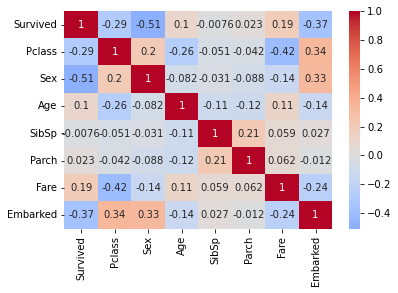

In [110]:
sns.heatmap(pd.DataFrame.corr(train_data), annot=True, center=0, cmap='coolwarm');

In [111]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

I tried a lot of new features and feature combinations, you can see my thoughts in the commented lines in the next sells. The final variant of preprocessing is presented in the function `preprocessing_1`.

In [112]:
def preprocessing_1(df_1):
    # dropping unused columns
    df_1 = df_1.drop(['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], axis=1)
    
    # filling missing values as described at the beginning
    df_1['Embarked'] = df_1['Embarked'].fillna('S')

    dict_mean_age = dict(df_1.groupby('Pclass')['Age'].aggregate('mean'))
    df_1['mean_age'] = df_1['Pclass'].map(dict_mean_age)
    df_1['Age'] = df_1['Age'].fillna(df_1['mean_age'])
    df_1 = df_1.drop('mean_age', axis=1)
    #train_data['Age'] = train_data['Age'].apply(lambda x: floor(x) if not np.isnan(x) else x)

    dict_mean_fare = dict(df_1.groupby('Pclass')['Fare'].aggregate('mean'))
    df_1['mean_fare'] = df_1['Pclass'].map(dict_mean_fare)
    df_1['Fare'] = df_1['Fare'].fillna(df_1['mean_fare'])
    df_1 = df_1.drop('mean_fare', axis=1)
    
    # making binary column for Embarked - S or not S
    df_1['Embarked_bin'] = df_1['Embarked'].apply(lambda x: 0 if x=='S' else 1)
    df_1 = df_1.drop('Embarked', axis=1)

    # making binary column for Sex: 0-female, 1-male
    df_1['Sex'] = df_1['Sex'].replace({'female': 0, 'male': 1})
    
    return df_1

In [113]:
train_data = data
train_data = preprocessing_1(train_data)

In [114]:
#train_data['Cabin_letter'] = train_data['Cabin'].apply(lambda x: 'G' if str(x)[0] == 'n' else str(x)[0])
#train_data['Cabin_letter'] = train_data['Cabin'].apply(lambda x: str(x)[0])
#train_data = train_data.drop('Cabin', axis=1)

In [115]:
#train_data['Cabin_letter_bin'] = train_data['Cabin_letter'].apply(lambda x: 0 if x in 'FGn' else 1)
#train_data = train_data.drop('Cabin_letter', axis=1)

In [116]:
#train_data['Relatives'] = train_data['SibSp'] + train_data['Parch']
#train_data = train_data.drop(['SibSp', 'Parch'], axis=1)

In [117]:
#train_data['Relatives_bin'] = train_data['Relatives'].apply(lambda x: 0 if x==0 else 1)
#train_data = train_data.drop(['Relatives'], axis=1)

In [118]:
#train_data['Child_bin'] = train_data['Age'].apply(lambda x: 0 if x<=13 else 1)

In [119]:
#train_data['Pclass_bin'] = train_data['Pclass'].apply(lambda x: 0 if x==3 else 1)
#train_data = train_data.drop('Pclass', axis=1)

In [120]:
#train_data['Sex_Pclass'] = 10 * train_data['Sex'] + train_data['Pclass']

In [121]:
#train_data['Sex_Child'] = 10 * train_data['Sex'] + train_data['Child_bin']

In [122]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Survived      100000 non-null  int64  
 1   Pclass        100000 non-null  int64  
 2   Sex           100000 non-null  int64  
 3   Age           100000 non-null  float64
 4   Fare          100000 non-null  float64
 5   Embarked_bin  100000 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 5.3 MB


In [123]:
#train_data['Sex_bin'] = train_data['Sex'].apply(lambda x: 0 if x=='Female' else 1)
#train_data = train_data.drop('Sex', axis=1)

In [124]:
#train_data_encoded_dummies = train_data
#train_data_encoded_dummies = pd.get_dummies(train_data_encoded_dummies, columns=['Sex_Child'])

In [125]:
X = train_data.drop(['Survived'], axis=1)
y = train_data['Survived']

In [126]:
X

,Pclass,Sex,Age,Fare,Embarked_bin
PassengerId,,,,,
0,1,1,44.774464,27.14,0
1,3,1,33.407362,13.35,0
2,3,1,0.330000,71.29,0
3,3,1,19.000000,13.04,0
4,3,1,25.000000,7.76,0
...,...,...,...,...,...
99995,2,0,62.000000,14.86,1
99996,2,1,66.000000,11.15,0
99997,3,1,37.000000,9.95,0


In [127]:
log_reg = LogisticRegression(penalty='l2', max_iter=1000, solver='liblinear', random_state=SEED)
log_reg.fit(X, y)
#print(accuracy_score(y, log_reg.predict(X)))
cv_results_log_reg = cross_validate(log_reg, X, y, cv=5, scoring='accuracy', return_train_score=True)
cv_results_log_reg['test_score']

array([0.7609 , 0.7665 , 0.76275, 0.76095, 0.76245])

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X, y)
cv_results_knn = cross_validate(knn, X, y, cv=3, scoring='accuracy', return_train_score=True)
cv_results_knn['test_score']

Logistic Regression in this block again shows better results, so I'll submit the results of this model to Kaggle.

In [ ]:
test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [ ]:
test.info()

In [ ]:
test_data = preprocessing_1(test)
results = log_reg.predict(test_data)

In [ ]:
results_df = pd.DataFrame({'PassengerId': [i for i in range(100000, 200000)],
                                  'Survived': list(results)},
                                 index=[i for i in range(100000)])
results_df

In [ ]:
results_df.to_csv('results_Ogneva.csv', index=False)

It was my first model to submit to kaggle, **public score is 0.80140 and should cost 2,5 points**.

![submit_1](./submit_1.png)

*The screenshot was done about 8PM on Sunday*

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.